# Feature Selection/Extraction
In this lab session we will use the library scikit-learn to work with the titanic dataset we will apply some feature selection techniques and experiment with dimensionality reduction by using:
1. Principal Component Analysis (PCA)
2. Linear Discriminant Analysis (LDA)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
%config InlineBackend.figure_format = 'svg'
%matplotlib inline

from sklearn.compose import ColumnTransformer
from sklearn.metrics import classification_report, plot_confusion_matrix
from sklearn.datasets import fetch_openml
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings('ignore')

### Question 1
Load the titanic data from scikit learn, the data contains information about the passengers on board the titanic, we will be using that data to predict if a passenger survives the accident or not <br>
After loading the dataset split it into training and testing sets with 20% of the data in the testing set.

In [2]:
np.random.seed(42)
X, y = fetch_openml("titanic", version=1, as_frame=True, return_X_y=True)
X.drop(['boat', 'body', 'home.dest'], axis=1, inplace=True)

In [3]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [4]:
X_train.head()

,pclass,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked
772,3.0,"Dika, Mr. Mirko",male,17.0,0.0,0.0,349232,7.8958,None,S
543,2.0,"Reeves, Mr. David",male,36.0,0.0,0.0,C.A. 17248,10.5000,None,S
289,1.0,"Taussig, Miss. Ruth",female,18.0,0.0,2.0,110413,79.6500,E68,S
10,1.0,"Astor, Col. John Jacob",male,47.0,1.0,0.0,PC 17757,227.5250,C62 C64,C
147,1.0,"Harrington, Mr. Charles H",male,NaN,0.0,0.0,113796,42.4000,None,S


### Question 2
Check if any of the features have missing values and remove those with high missing value ratio

In [5]:
X_train.isnull().any()

pclass      False
name        False
sex         False
age          True
sibsp       False
parch       False
ticket      False
fare         True
cabin        True
embarked     True
dtype: bool

In [6]:
X_train.isnull().sum() / len(X_train) * 100

pclass       0.000000
name         0.000000
sex          0.000000
age         19.770774
sibsp        0.000000
parch        0.000000
ticket       0.000000
fare         0.095511
cabin       77.650430
embarked     0.095511
dtype: float64

In [7]:
X_test.isnull().sum() / len(X_test) * 100

pclass       0.000000
name         0.000000
sex          0.000000
age         21.374046
sibsp        0.000000
parch        0.000000
ticket       0.000000
fare         0.000000
cabin       76.717557
embarked     0.381679
dtype: float64

In [8]:
X_train.drop(['cabin'], axis=1, inplace=True)
X_test.drop(['cabin'], axis=1, inplace=True) 
X_train.dropna(subset=['fare', 'embarked'], inplace=True)
y_train = y_train[X_train.index]
X_test.dropna(subset=['embarked'], inplace=True)
y_test = y_test[X_test.index]

In [9]:
X_train.isnull().sum() / len(X_train) * 100

pclass       0.000000
name         0.000000
sex          0.000000
age         19.808612
sibsp        0.000000
parch        0.000000
ticket       0.000000
fare         0.000000
embarked     0.000000
dtype: float64

In [10]:
X_test.isnull().sum() / len(X_test) * 100

pclass       0.000000
name         0.000000
sex          0.000000
age         21.455939
sibsp        0.000000
parch        0.000000
ticket       0.000000
fare         0.000000
embarked     0.000000
dtype: float64

### Question 3
Plot the correlation matrix of the numerical data.

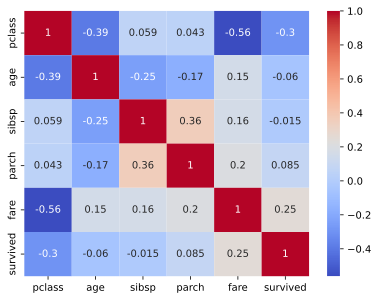

In [11]:
X_comb = pd.concat([X_train, y_train.astype(float)], axis=1)
g = sns.heatmap(X_comb[['pclass', 'sex', 'age', 'sibsp', 'parch', 'fare', 'survived']].corr(),
                annot=True, 
                cmap = "coolwarm")

### Question 4
Combine the parch and sibsp features into one feature called family_size since they are highly correlated.

In [12]:
for dataset in [X_train, X_test]:
    dataset['family_size'] = dataset['parch'] + dataset['sibsp']
    dataset.drop(['parch', 'sibsp'], axis=1, inplace=True)
    dataset['is_alone'] = 1
    dataset['is_alone'].loc[dataset['family_size'] > 1] = 0

X_train.head()

,pclass,name,sex,age,ticket,fare,embarked,family_size,is_alone
772,3.0,"Dika, Mr. Mirko",male,17.0,349232,7.8958,S,0.0,1
543,2.0,"Reeves, Mr. David",male,36.0,C.A. 17248,10.5000,S,0.0,1
289,1.0,"Taussig, Miss. Ruth",female,18.0,110413,79.6500,S,2.0,0
10,1.0,"Astor, Col. John Jacob",male,47.0,PC 17757,227.5250,C,1.0,1
147,1.0,"Harrington, Mr. Charles H",male,NaN,113796,42.4000,S,0.0,1


### Question 5
Extract the title form the 'name' feature so that we can get some useful information from it.
Check all the titles created for males and females and group those that are redundant or rare.

In [13]:
for dataset in [X_train, X_test]:
    dataset['title'] =  dataset['name'].str.split(", ", expand=True)[1].str.split(".", expand=True)[0]
    dataset.drop(["name"], axis=1, inplace=True)

X_train.head()

,pclass,sex,age,ticket,fare,embarked,family_size,is_alone,title
772,3.0,male,17.0,349232,7.8958,S,0.0,1,Mr
543,2.0,male,36.0,C.A. 17248,10.5000,S,0.0,1,Mr
289,1.0,female,18.0,110413,79.6500,S,2.0,0,Miss
10,1.0,male,47.0,PC 17757,227.5250,C,1.0,1,Col
147,1.0,male,NaN,113796,42.4000,S,0.0,1,Mr


In [14]:
pd.crosstab(X_train['title'], X_train['sex'])

sex,female,male
title,,
Col,0,4
Don,0,1
Dr,1,7
Jonkheer,0,1
Lady,1,0
Major,0,1
Master,0,50
Miss,210,0
Mlle,1,0


In [15]:
print(f"Miss: {np.sum(y_train.astype(int)[X_train.title == 'Miss']) / len(X_train.title == 'Miss')}")
print(f"Mrs: {np.sum(y_train.astype(int)[X_train.title == 'Mrs']) / len(X_train.title == 'Mrs')}")

Miss: 0.13301435406698564
Mrs: 0.11291866028708133


In [16]:
X_comb = pd.concat([X_train, X_test])
rare_titles = (X_comb['title'].value_counts() < 10)
rare_titles

Mr              False
Miss            False
Mrs             False
Master          False
Rev              True
Dr               True
Col              True
Ms               True
Mlle             True
Major            True
Don              True
Mme              True
Jonkheer         True
Lady             True
the Countess     True
Sir              True
Capt             True
Dona             True
Name: title, dtype: bool

In [17]:
for dataset in [X_train, X_test]:
    dataset.title.loc[dataset.title == 'Miss'] = 'Mrs'
    dataset['title'] = dataset.title.apply(lambda x: 'rare' if rare_titles[x] else x)

In [18]:
for dataset in [X_train, X_test]:
    dataset.drop('ticket', axis=1, inplace=True)

X_train.head()

,pclass,sex,age,fare,embarked,family_size,is_alone,title
772,3.0,male,17.0,7.8958,S,0.0,1,Mr
543,2.0,male,36.0,10.5000,S,0.0,1,Mr
289,1.0,female,18.0,79.6500,S,2.0,0,Mrs
10,1.0,male,47.0,227.5250,C,1.0,1,rare
147,1.0,male,NaN,42.4000,S,0.0,1,Mr


### Question 6
Check which features are categorical and which are numerical, and define two different transformers to preprocess the data. <br>
For categorical features replace the missing values by the most frequent one and onehot encode the categories.<br>
For numerical features replace the missing values with the mean and normalize the data.

In [19]:
X_train.dtypes

pclass          float64
sex            category
age             float64
fare            float64
embarked       category
family_size     float64
is_alone          int64
title            object
dtype: object

In [20]:
cat_cols = ['embarked', 'sex', 'pclass', 'title', 'is_alone']
cat_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse=False))
])

In [21]:
num_cols = ['age', 'fare', 'family_size']
num_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

In [22]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', num_transformer, num_cols),
        ('cat', cat_transformer, cat_cols)
    ])

### Question 7
Define a pipeline that preprocesses the data and then fits it into a random forest classifier.<br>
Fit the data and evaluate the data on the testing set.

In [23]:
model = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', RandomForestClassifier())])

In [24]:
model.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['age', 'fare',
                                                   'family_size']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse=False))]),
                                                  ['embarked', 'sex', 'pclass',
                                                   'title', 'is_alone'])])),
                ('classifier', RandomForestClassifier())])

In [25]:
y_pred = model.predict(X_test)

In [26]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.76      0.85      0.81       144
           1       0.79      0.68      0.73       117

    accuracy                           0.77       261
   macro avg       0.78      0.76      0.77       261
weighted avg       0.78      0.77      0.77       261



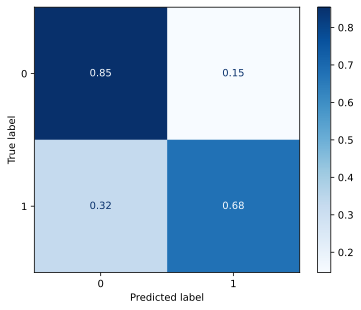

In [27]:
plot_confusion_matrix(model, X_test, y_test, cmap=plt.cm.Blues, normalize='true')

### Question 8
Redo question 7, but apply PCA to the preprocessed data before fitting it to reduce the dimension of the features, change the number of components used in PCA and check how that affects the testing accuracy.

In [28]:
modelpca = Pipeline(steps=[('preprocessor', preprocessor),
                      ('pca', PCA(n_components=2)),
                      ('classifier', RandomForestClassifier())])

In [29]:
modelpca.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['age', 'fare',
                                                   'family_size']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse=False))]),
                                                  ['embarked', 'sex', 'pclass',
                                                   'title', 'is_alone'])])),
                ('pca', PCA(n_components=2)),
                ('classifier', RandomForestClassifier())])

In [30]:
y_pred = modelpca.predict(X_test)

In [31]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.70      0.81      0.75       144
           1       0.72      0.58      0.64       117

    accuracy                           0.71       261
   macro avg       0.71      0.70      0.70       261
weighted avg       0.71      0.71      0.70       261



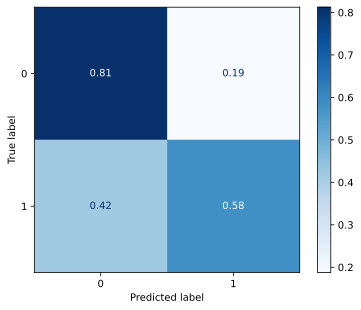

In [32]:
plot_confusion_matrix(modelpca, X_test, y_test, cmap=plt.cm.Blues, normalize='true')

### Question 9
Redo question 7, but apply LDA to the preprocessed data before fitting it to reduce the dimension of the features, and check how that affects the testing accuracy.

In [33]:
modellda = Pipeline(steps=[('preprocessor', preprocessor),
                      ('lda', LinearDiscriminantAnalysis(n_components=1)),
                      ('classifier', RandomForestClassifier())])

In [34]:
modellda.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['age', 'fare',
                                                   'family_size']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse=False))]),
                                                  ['embarked', 'sex', 'pclass',
                                                   'title', 'is_alone'])])),
                ('lda', LinearDiscriminantAnalysis(n_components=1)),
                ('classifier', RandomForestClassifier())])

In [35]:
y_pred = modellda.predict(X_test)

In [36]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.75      0.81      0.78       144
           1       0.74      0.66      0.70       117

    accuracy                           0.74       261
   macro avg       0.74      0.74      0.74       261
weighted avg       0.74      0.74      0.74       261



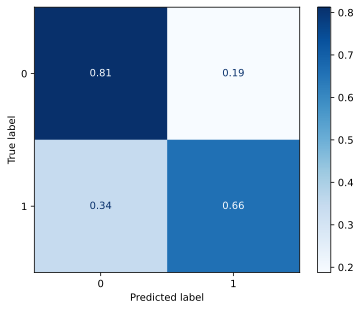

In [37]:
plot_confusion_matrix(modellda, X_test, y_test, cmap=plt.cm.Blues, normalize='true')